## Importing Necessary Libraries

In [1]:
#Import the necessary libraries
import cPickle
from sklearn.ensemble import RandomForestClassifier
from sklearn import grid_search
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

print "libraries have been imported"

libraries have been imported


## Functions to Read in the data and split it into test and train

In [2]:
#Function to unpickle the image files and return the CIFAR dictionary containing the data and the labels
def unpickle(file):
    fo = open(file, 'rb')
    dict = cPickle.load(fo)
    fo.close()
    return dict

In [3]:
def split_test_train(cifar_data, seed_val):
    '''This function takes in one of the cifar datasets and randomly splits the data into test (20%) and train (80%).
    It returns a dictionary with four data structures:
    1. train_data (numpy array)
    2. train_labels (list)
    3. test_data (numpy array)
    4. test_labels (list)'''
    
    from numpy.random import seed

    #set a seed and randomly split into training and test
    seed(seed_val)
    
    #Get the data and labels
    all_data = cifar_data['data']
    all_labels = cifar_data['labels']
    
    #Randomly sample indexes from the data
    indexes = np.random.choice(len(all_data), size = len(all_data), replace = False)
    
    #Split into Test and Train
    train_amount = int(round(0.8 * len(indexes)))
    train_data = all_data[indexes[:train_amount]]
    train_labels = [all_labels[i] for i in indexes[:train_amount]]
    test_data = all_data[indexes[train_amount:]]
    test_labels = [all_labels[i] for i in indexes[train_amount:]]
    
    #Put it all in a dictionary and return the dictionary
    split_data = {"train_data": train_data, "train_labels": train_labels, "test_data": test_data, "test_labels": test_labels}
    return split_data

## Reading in the first two batches of cifar-10 data and splitting into test and train

In [4]:
#Read in the first two batches of data (the batch must reside in a folder called 'data' that resides in the parent folder of the current directory)
#The pickle file contains two elements --> 'data' (numpy array) and 'labels' (numeric list)
batch1 = unpickle("data/data_batch_1")
batch2 = unpickle("data/data_batch_2")

#Read in the label names for these images
label_names = unpickle("data/batches.meta")

#Note: I'm splitting these up individually and then combining them (rather than combining them and then splitting them up)
#simply because I already have the code written to do it this way...
split_data1 = split_test_train(batch1, 4)
split_data2 = split_test_train(batch2, 5)

#Concatenate the two data sets
all_train_data = np.concatenate((split_data1['train_data'], split_data2['train_data']), axis = 0)
all_train_labels = split_data1['train_labels'] + split_data2['train_labels']
all_test_data = np.concatenate((split_data1['test_data'], split_data2['test_data']), axis = 0)
all_test_labels = split_data1['test_labels'] + split_data2['test_labels']

print all_train_data.shape

(16000, 3072)


## Get training and test sets in proper format for skimage and matplotlib

In [5]:
#change to [[r,g,b][r,g,b]...[r,g,b]] rather than [rrrr....gggg....bbbb]
def format_as_rgb_channels(raw_data):
    return [row.reshape(3,1024).swapaxes(0,1).reshape(32,32,3) for row in raw_data]

rgb_train_data = format_as_rgb_channels(all_train_data)
rgb_test_data = format_as_rgb_channels(all_test_data)


## Function to visualize images

In [6]:
def visualize(rgb_data):
    """Simple visualization function"""
    plt.imshow(rgb_data)
    plt.show()
    
def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.gray() # Only place in this blog you can't replace 'gray' with 'grey'
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

## Trying some Feature Engineering with scikit-image

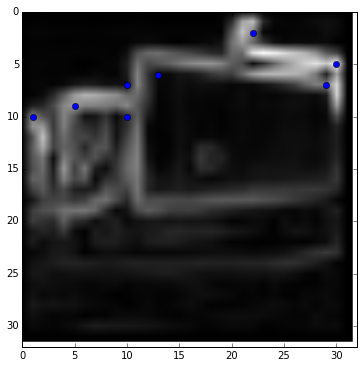

Number of corners: 8


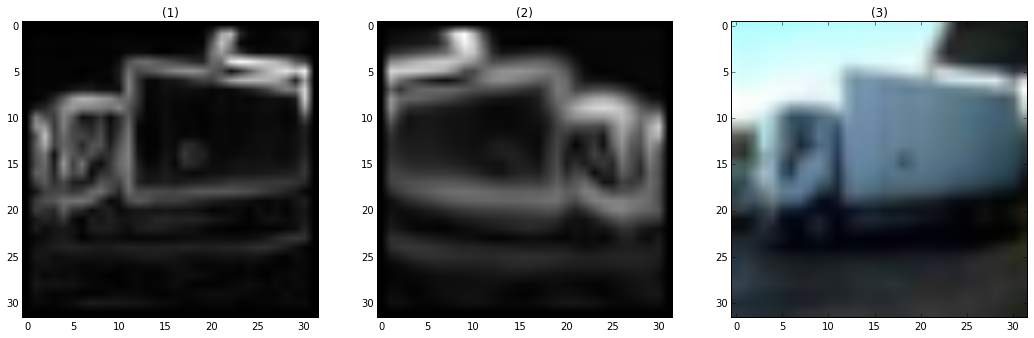

In [22]:
from skimage.feature import corner_harris,corner_peaks
from skimage.color import rgb2gray
from skimage.filters import gaussian_filter
from skimage.filters import roberts, sobel, scharr

# More pyplot!
def show_corners(corners,image,title=None):
    """Display a list of corners overlapping an image"""
    fig = plt.figure()
    plt.imshow(image)
    # Convert coordinates to x and y lists
    y_corner,x_corner = zip(*corners)
    plt.plot(x_corner,y_corner,'o') # Plot corners
    if title:
        plt.title(title)
    plt.xlim(0,image.shape[1])
    plt.ylim(image.shape[0],0) # Images use weird axes
    fig.set_size_inches(np.array(fig.get_size_inches()) * 1.5)
    plt.show()
    print "Number of corners:",len(corners)
    
target = rgb_train_data[990]
edge_sobel = sobel(gaussian_filter(rgb2gray(target), sigma=1))
edge_roberts = roberts(rgb2gray(target))

# Run Harris
target_corners = corner_peaks(corner_harris(edge_roberts),min_distance=1)
show_corners(target_corners,edge_roberts)
show_images(images=[edge_roberts, np.fliplr(edge_sobel), target])

## Running the RF with the optimized hyper-parameters over the non-pre-processed data (takes about 5 minutes to run on my computer)

In [38]:
# try applying sobel edge detection to image
#sobel_train = np.array([np.ravel(sobel(rgb2gray(img))) for img in rgb_train_data])
#sobel_test = np.array([np.ravel(sobel(rgb2gray(img))) for img in rgb_test_data])

#try applying roberts edge detection
#roberts_train = np.array([np.ravel(roberts(rgb2gray(img))) for img in rgb_train_data])
#roberts_test = np.array([np.ravel(roberts(rgb2gray(img))) for img in rgb_test_data])

#try 180 deg rotation
rotate_train = np.array([np.ravel(np.fliplr(img)) for img in rgb_train_data])
rotate_test = np.array([np.ravel(np.fliplr(img)) for img in rgb_test_data])

# add number of corners
#corners_train = np.array([[corner_peaks(corner_harris(sobel(rgb2gray(img))),min_distance=2).shape[0] for img in rgb_train_data]])
#corners_test = np.array([[corner_peaks(corner_harris(sobel(rgb2gray(img))),min_distance=2).shape[0] for img in rgb_test_data]])

#train = np.concatenate((sobel_train, corners_train.T), axis=1)
#test = np.concatenate((sobel_test, corners_test.T), axis=1)

#train = np.hstack((all_train_data, roberts_train))
#test = np.hstack((all_test_data, roberts_test))

train_subset = np.concatenate((all_train_data[:1000,:], rotate_train[:1000,:]))
test_subset = np.concatenate((all_test_data[:800,:], rotate_test[:800,:]))
train_labels_subset = np.concatenate((all_train_labels[:1000], all_train_labels[:1000]))
test_labels_subset =  np.concatenate((all_test_labels[:800], all_test_labels[:800]))

print train_subset.shape
#train_subset = train[:1000,:]
#train_labels_subset = all_train_labels[:1000]
#test_subset = test[:800,:]
#test_labels_subset = all_test_labels[:800]

(2000, 3072)


In [37]:
#Here is the random forest run with they ideal hyperparameters (obtained from a 'grid search' cross-validation)
new_rf2 = RandomForestClassifier(n_estimators=500, min_samples_leaf=1, min_samples_split=2)
new_rf2.fit(train_subset, train_labels_subset)
print 'Accuracy on test data:', round(new_rf2.score(test_subset, test_labels_subset), 3) * 100

Accuracy on test data: 34.7


## Results from previous runs

Results with rotation + color images:
Accuracy on test data: 34.7

Results with sobel edge + color images
Accuracy on test data: 37.9

Results with roberts + color images
Accuracy on test data: 36.6

Results with greyscale, sobel edge detection, and gaussian blur
Accuracy on test data: 27.6

Results with greyscale, sobel edge detection
Accuracy on test data: 38.1

Results with greyscale, sobel edge, and # of corners appended
Accuracy on test data: 29.0

Baseline
Accuracy on test data: 38.4

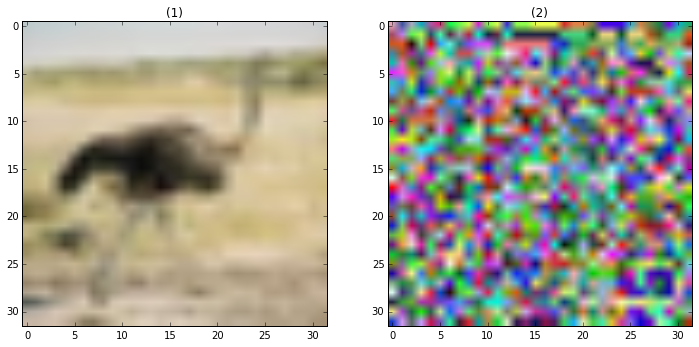

In [34]:
from skimage.color import rgb2lab
target = rgb_train_data[1]
result = rgb2lab(target)
show_images(images=[target, result])